**By: Saskia Dwi Ulfah**

# **0: CONNECT TO GOOGLE DRIVE**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **1: IMPORT LIBRARIES**

In [3]:
import os
from skimage.io import imread,imshow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import ModelCheckpoint,EarlyStopping

# **2: DATA PREPARATION**

In [4]:
SIZE_X = 256 
SIZE_Y = 256
n_classes = 1

## 2.1: Basic checking

In [5]:
ROOT_PATH = '/content/drive/MyDrive/Omdena/Challenge: Breast Cancer Detection/Breast Cancer Segmentation/Dataset_BUSI_with_GT'

In [6]:
os.listdir(ROOT_PATH)

['malignant', 'normal', 'benign']

In [7]:
print("Number of images in normal folder: {} images".format(len(os.listdir(os.path.join(ROOT_PATH, 'normal')))))
print("Number of images in benign folder: {} images".format(len(os.listdir(os.path.join(ROOT_PATH, 'benign')))))
print("Number of images in malignant folder: {} images".format(len(os.listdir(os.path.join(ROOT_PATH, 'malignant')))))

Number of images in normal folder: 266 images
Number of images in benign folder: 891 images
Number of images in malignant folder: 421 images


In [8]:
# for every data: save its image and mask filenames

images_filename = []
masks_filename = []

for folder in os.listdir(ROOT_PATH):
  # iterate over normal, benign, and malignant folders
  for file in sorted(os.listdir(os.path.join(ROOT_PATH, folder))):
    if '_mask' in file:
      masks_filename.append(file)
    else:
      images_filename.append(file)

In [9]:
len(images_filename), len(masks_filename)

(780, 798)

## 2.2: Remove masks that end with '_1' or '_2'

In [10]:
# more_than_one_mask contains image filename that have more than 1 mask

masks_filter = [x.replace('_mask','') for x in masks_filename]
more_than_one_mask = sorted(set(sorted(masks_filter)) - set(sorted(images_filename)))
more_than_one_mask

# Benign 100,
# Benign 163,
# Benign 173,
# Benign 181,
# Benign 195,
# Benign 25, 
# Benign 315,
# Benign 346,
# Benign 4,
# Benign 424,
# Benign 54.
# Benign 58,
# Benign 83,
# Benign 92,
# Benign 93,
# Benign 98
# Malignant 53

['benign (100)_1.png',
 'benign (163)_1.png',
 'benign (173)_1.png',
 'benign (181)_1.png',
 'benign (195)_1.png',
 'benign (195)_2.png',
 'benign (25)_1.png',
 'benign (315)_1.png',
 'benign (346)_1.png',
 'benign (4)_1.png',
 'benign (424)_1.png',
 'benign (54)_1.png',
 'benign (58)_1.png',
 'benign (83)_1.png',
 'benign (92)_1.png',
 'benign (93)_1.png',
 'benign (98)_1.png',
 'malignant (53)_1.png']

In [11]:
more_than_one_mask = [x[:-6]+'_mask'+x[-6:] for x in more_than_one_mask]
more_than_one_mask

['benign (100)_mask_1.png',
 'benign (163)_mask_1.png',
 'benign (173)_mask_1.png',
 'benign (181)_mask_1.png',
 'benign (195)_mask_1.png',
 'benign (195)_mask_2.png',
 'benign (25)_mask_1.png',
 'benign (315)_mask_1.png',
 'benign (346)_mask_1.png',
 'benign (4)_mask_1.png',
 'benign (424)_mask_1.png',
 'benign (54)_mask_1.png',
 'benign (58)_mask_1.png',
 'benign (83)_mask_1.png',
 'benign (92)_mask_1.png',
 'benign (93)_mask_1.png',
 'benign (98)_mask_1.png',
 'malignant (53)_mask_1.png']

In [12]:
# drop mask in more_than_one_mask

for file_name in masks_filename:
  if file_name in more_than_one_mask:
    masks_filename.remove(file_name)
masks_filename.remove('benign (195)_mask_2.png')

In [13]:
len(images_filename), len(masks_filename)

(780, 780)

In [14]:
pd.DataFrame({
    'Images': images_filename,
    'Masks' : masks_filename
})

,Images,Masks
0,malignant (1).png,malignant (1)_mask.png
1,malignant (10).png,malignant (10)_mask.png
2,malignant (100).png,malignant (100)_mask.png
3,malignant (101).png,malignant (101)_mask.png
4,malignant (102).png,malignant (102)_mask.png
...,...,...
775,benign (95).png,benign (95)_mask.png
776,benign (96).png,benign (96)_mask.png
777,benign (97).png,benign (97)_mask.png
778,benign (98).png,benign (98)_mask.png


## 2.3: Save images and masks in arrays

In [15]:
images = []
masks = []

for folder in os.listdir(ROOT_PATH):
  # iterate over normal, benign, and malignant folders
  for file in sorted(os.listdir(os.path.join(ROOT_PATH, folder))):
    if '_mask' in file:
      if file in masks_filename:
        mask = cv.imread(os.path.join(ROOT_PATH, folder, file),cv.IMREAD_GRAYSCALE)
        mask = cv.resize(mask,(SIZE_Y,SIZE_X))
        masks.append(mask)
    else:
        img = cv.imread(os.path.join(ROOT_PATH, folder, file))
        img = cv.resize(img,(SIZE_Y,SIZE_X))
        images.append(img)

In [16]:
images = np.array(images)
masks = np.array(masks)

In [17]:
images.shape, masks.shape

((780, 256, 256, 3), (780, 256, 256))

In [18]:
X = images
y = masks

In [19]:
X = X/255
y = y/255

## 2.4: Sample of image and mask

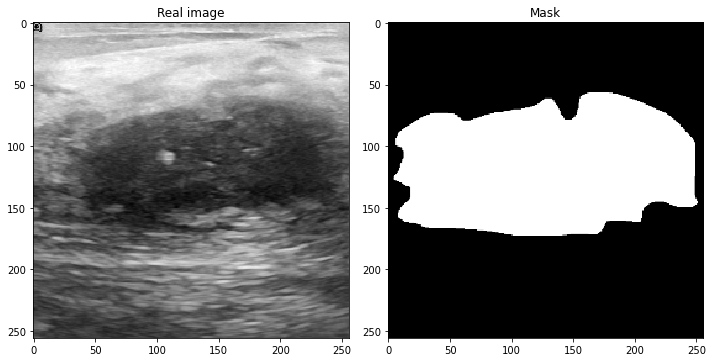

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.title('Real image')
imshow(X[0])

plt.subplot(122)
plt.title('Mask')
imshow(y[0], cmap='gray')

## **2.5: Train-test split**

In [21]:
y = np.expand_dims(y, 3)
X.shape, y.shape

((780, 256, 256, 3), (780, 256, 256, 1))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((702, 256, 256, 3), (78, 256, 256, 3), (702, 256, 256, 1), (78, 256, 256, 1))

# **3. U-Net Implementation**

In [24]:
def unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
 
    # Bottleneck
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [25]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
  return unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [26]:
model = get_model()

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [30]:
early_stopping = EarlyStopping(    
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

In [31]:
history = model.fit(X_train, y_train, 
                    epochs=100,
                    batch_size=32, 
                    verbose=1, 
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    shuffle=True)

Epoch 1/100
20/20 [==============================] - 20s 557ms/step - loss: 0.3711 - accuracy: 0.9004 - val_loss: 0.2577 - val_accuracy: 0.9376
Epoch 2/100
20/20 [==============================] - 6s 314ms/step - loss: 0.2913 - accuracy: 0.9187 - val_loss: 0.2332 - val_accuracy: 0.9376
Epoch 3/100
20/20 [==============================] - 6s 315ms/step - loss: 0.2456 - accuracy: 0.9187 - val_loss: 0.1811 - val_accuracy: 0.9376
Epoch 4/100
20/20 [==============================] - 6s 316ms/step - loss: 0.2242 - accuracy: 0.9187 - val_loss: 0.1668 - val_accuracy: 0.9376
Epoch 5/100
20/20 [==============================] - 6s 318ms/step - loss: 0.2187 - accuracy: 0.9190 - val_loss: 0.1801 - val_accuracy: 0.9376
Epoch 6/100
20/20 [==============================] - 6s 321ms/step - loss: 0.2077 - accuracy: 0.9210 - val_loss: 0.1683 - val_accuracy: 0.9395
Epoch 7/100
20/20 [==============================] - 6s 322ms/step - loss: 0.1972 - accuracy: 0.9253 - val_loss: 0.1525 - val_accuracy: 0.945

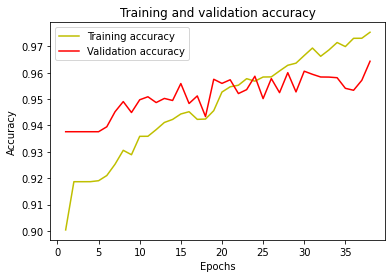

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

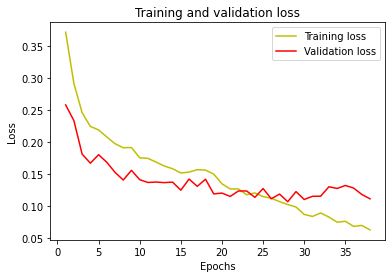

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
model.save("/content/drive/MyDrive/Omdena/Challenge: Breast Cancer Detection/Breast Cancer Segmentation/U-Net.hdf5")

In [37]:
# test image

test_image = np.expand_dims(X_test[0], axis=0)
predicted_mask = model.predict(test_image)

1/1 [==============================] - 1s 1s/step


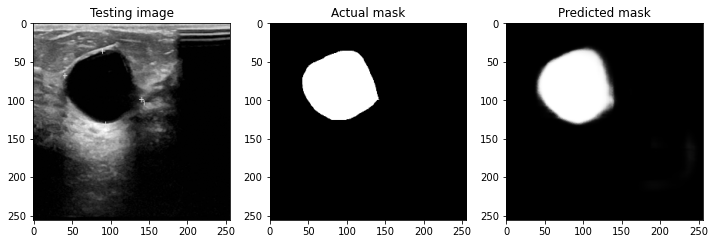

In [57]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(X_test[0])

plt.subplot(232)
plt.title('Actual mask')
plt.imshow(y_test[0][:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Predicted mask')
plt.imshow(predicted_mask.reshape(y_test[0].shape)[:,:,0], cmap='gray')
plt.show()

# https://stackoverflow.com/questions/42935973/i-am-getting-error-with-im-show

In [59]:
# test image 2

test_image_2 = np.expand_dims(X_test[10], axis=0)
predicted_mask_2 = model.predict(test_image_2)

1/1 [==============================] - 0s 17ms/step


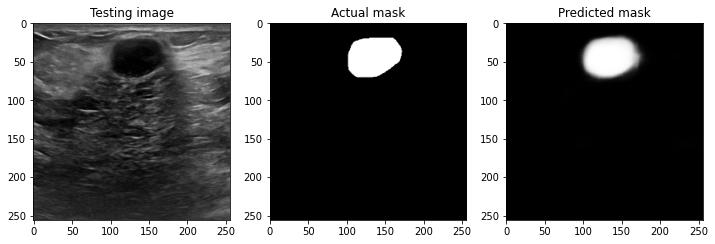

In [61]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(X_test[10])

plt.subplot(232)
plt.title('Actual mask')
plt.imshow(y_test[10][:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Predicted mask')
plt.imshow(predicted_mask_2.reshape(y_test[10].shape)[:,:,0], cmap='gray')
plt.show()

In [64]:
# test image 3

test_image_3 = np.expand_dims(X_test[50], axis=0)
predicted_mask_3 = model.predict(test_image_3)

1/1 [==============================] - 0s 23ms/step


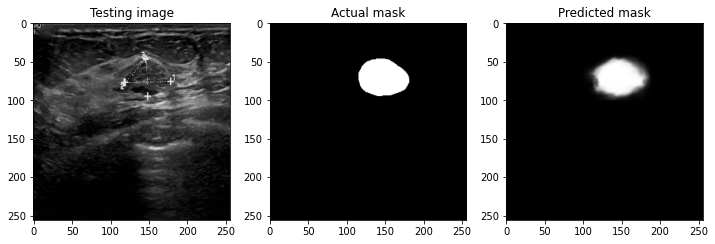

In [65]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(X_test[50])

plt.subplot(232)
plt.title('Actual mask')
plt.imshow(y_test[50][:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Predicted mask')
plt.imshow(predicted_mask_3.reshape(y_test[50].shape)[:,:,0], cmap='gray')
plt.show()